# **Consistent Non-Annotated Train-Validation Split**

- Just splitting the training data now, so that there is consistency between all the other stages of the training and feature extraction process
- It will be a 75-25 split of the training data

In [1]:
# Standard libraries
import numpy as np
import pandas as pd
import os
import time

# Libraries for audio
from IPython.display import Audio
import librosa

# Training and Testing Split
from sklearn.model_selection import train_test_split

# for normalization & avgpooling features
from sklearn.preprocessing import MinMaxScaler # to squeeze all the features to be within 0 and 1
import tensorflow as tf

# Operational
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

In [2]:
# Variabels to be reused
path = 'C:/Users/thato/Documents/Final-Year-Project/Dataset/Final-Version-Of-Bird-Classification-Project/audio_files' 
npy_path = 'C:/Users/thato/Documents/Final-Year-Project/Dataset/Final-Version-Of-Bird-Classification-Project/train_audio_npy/' 
train_csv = 'C:/Users/thato/Documents/Final-Year-Project/Dataset/Final-Version-Of-Bird-Classification-Project/train-not-annotated.csv' 
annotated_train_csv = 'C:/Users/thato/Documents/Final-Year-Project/Dataset/Final-Version-Of-Bird-Classification-Project/train-annotated.csv'
sr = 22050

In [5]:
df_train = pd.read_csv(train_csv) # Reading in training data
df_train.head()

,Unnamed: 0,species,audio_name,duration,filename_npy
0,0,Alcedo atthis,XC538941.mp3,141.528980,Alcedo atthis/XC538941.npy
1,1,Ciconia ciconia,XC27569.mp3,82.076735,Ciconia ciconia/XC27569.npy
2,2,Ardea purpurea,XC191096.mp3,15.144036,Ardea purpurea/XC191096.npy
3,3,Ciconia ciconia,XC372950.mp3,12.483764,Ciconia ciconia/XC372950.npy
4,4,Ardea purpurea,XC311153.mp3,7.000816,Ardea purpurea/XC311153.npy


In [6]:
df_train['species'].value_counts()

species
Himantopus himantopus        54
Alcedo atthis                47
Tachybaptus ruficollis       46
Botaurus stellaris           40
Charadrius alexandrinus      38
Gallinula chloropus          38
Porphyrio porphyrio          37
Fulica atra                  36
Acrocephalus melanopogon     36
Ardea purpurea               30
Motacilla flava              26
Acrocephalus scirpaceus      26
Circus aeruginosus           26
Dendrocopos minor            24
Acrocephalus arundinaceus    24
Ciconia ciconia              24
Ixobrychus minutus           24
Coracias garrulus            17
Anas platyrhynchos           16
Anas strepera                 6
Name: count, dtype: int64

In [7]:
filepaths = df_train['filename_npy']

## Get the durations for all the species

In [8]:
duration_sum = df_train.groupby('species', as_index=False)['duration'].sum()
duration_sum['duration_mins'] = duration_sum['duration'] / 60
duration_sum = duration_sum.sort_values('duration', ascending=False)
duration_sum.head(20)

,species,duration,duration_mins
0,Acrocephalus arundinaceus,3295.533605,54.925560
2,Acrocephalus scirpaceus,3039.165125,50.652752
1,Acrocephalus melanopogon,2827.530612,47.125510
15,Himantopus himantopus,2351.560272,39.192671
7,Botaurus stellaris,2238.726440,37.312107
12,Dendrocopos minor,1901.548662,31.692478
19,Tachybaptus ruficollis,1549.153696,25.819228
3,Alcedo atthis,1499.677506,24.994625
11,Coracias garrulus,1264.029478,21.067158
16,Ixobrychus minutus,1213.241587,20.220693


# Do a 75-25 training and validation split for each species so enough intraspecies sample variation

In [9]:
shuffled_train = df_train.sample(frac=1, random_state=619) # shuffle the original df before splitting to train/val

In [13]:
def intraspecies_split(df, split_ratio=0.8):
    train_data = pd.DataFrame() 
    val_data = pd.DataFrame()    
    
    # Group by 'species' and split within each species
    for species in df['species'].unique():
        species_df = df[df['species'] == species].copy()
        
        species_df = species_df.sample(frac=1, random_state=619).reset_index(drop=True)
        train, val = train_test_split(species_df, train_size=split_ratio, random_state=619)
        
        # Concatenate the result back into the main train and validation dataframes
        train_data = pd.concat([train_data, train])
        val_data = pd.concat([val_data, val])
    
    # Reset the index of the final dataframes
    train_data = train_data.reset_index(drop=True)
    val_data = val_data.reset_index(drop=True)
    
    return train_data, val_data

In [14]:
# Doing the intraspecies split
train_df, val_df = intraspecies_split(shuffled_train)

In [15]:
# Check the results
print("Training set size:", len(train_df))
print("Validation set size:", len(val_df))

Training set size: 482
Validation set size: 133


### Confirm no duplicates and the samples in validation set are not in the training set

In [16]:
assert len(val_df) == val_df['filename_npy'].nunique()

In [17]:
assert len(train_df) == train_df['filename_npy'].nunique()

In [18]:
is_present = val_df['filename_npy'].isin(train_df['filename_npy']).any()

assert not is_present, "Validation set contains samples from training set!"

### Combining the training and validation sets into one set with a column identifying the set the samples belong to

In [19]:
train_df['set'] = 'tr'
val_df['set'] = 'val'

merged_train = pd.concat([train_df, val_df])

In [21]:
# Grouping by 'species' and 'set', summing durations
duration_sum = merged_train[['species', 'duration', 'set']].groupby(['species', 'set'], as_index=False).sum()
duration_sum['duration_mins'] = duration_sum['duration'] / 60
duration_sum = duration_sum.sort_values('species', ascending=False)
duration_sum.head(40)


,species,set,duration,duration_mins
39,Tachybaptus ruficollis,val,318.752109,5.312535
38,Tachybaptus ruficollis,tr,1230.401587,20.506693
37,Porphyrio porphyrio,val,240.061905,4.001032
36,Porphyrio porphyrio,tr,390.468481,6.507808
35,Motacilla flava,val,414.048073,6.900801
34,Motacilla flava,tr,736.928118,12.282135
33,Ixobrychus minutus,val,376.758095,6.279302
32,Ixobrychus minutus,tr,836.483492,13.941392
30,Himantopus himantopus,tr,1945.319909,32.421998
31,Himantopus himantopus,val,406.240363,6.770673


In [24]:
figuresave = 'C:/Users/thato/Documents/Final-Year-Project/Dataset/Final-Version-Of-Bird-Classification-Project/figures/EDA/'

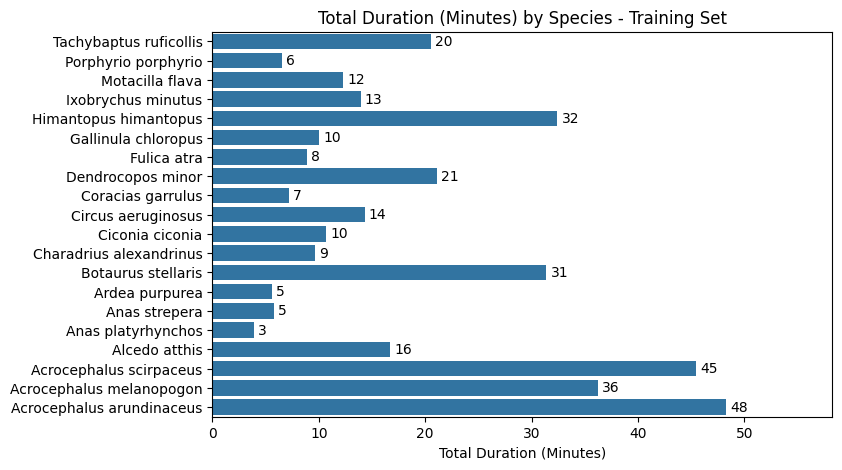

In [25]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8,5))
name = 'TotalDurationPerSpecies-TrainingSet'
sns.barplot(x='duration_mins', y='species', data=duration_sum[duration_sum['set'] =='tr'], ax=axes)
axes.bar_label(axes.containers[0], fmt='%i', padding=3)
axes.set(xlim=[0, np.max(duration_sum[duration_sum['set'] =='tr']['duration_mins']) + 10])
axes.set(ylabel='')
axes.set(xlabel='Total Duration (Minutes)')
axes.set(title='Total Duration (Minutes) by Species - Training Set')
plt.savefig(f'{figuresave + name}.pdf', dpi=300)

plt.show()

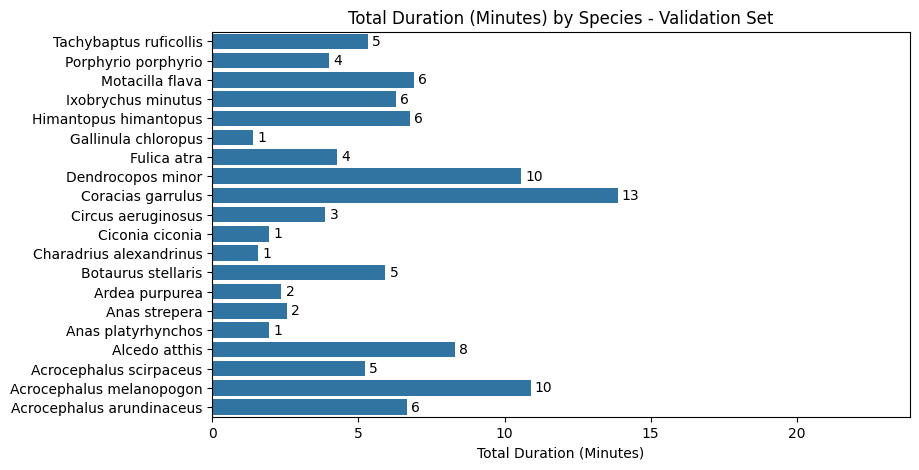

In [26]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(9,5))
name = 'TotalDurationPerSpecies-ValidationSet'
sns.barplot(x='duration_mins', y='species', data=duration_sum[duration_sum['set'] =='val'], ax=axes)
axes.bar_label(axes.containers[0], fmt='%i', padding=3)
axes.set(xlim=[0, np.max(duration_sum[duration_sum['set'] =='val']['duration_mins']) + 10])
axes.set(ylabel='')
axes.set(xlabel='Total Duration (Minutes)')
axes.set(title='Total Duration (Minutes) by Species - Validation Set')
plt.savefig(f'{figuresave + name}.pdf', dpi=300)
plt.show()

In [27]:
merged_train.to_csv('C:/Users/thato/Documents/Final-Year-Project/Dataset/Final-Version-Of-Bird-Classification-Project/trainval-split/trainval.csv', index=False)

In [28]:
merged_train

,Unnamed: 0,species,audio_name,duration,filename_npy,set
0,552,Himantopus himantopus,XC184422.mp3,155.899864,Himantopus himantopus/XC184422.npy,tr
1,560,Himantopus himantopus,XC67351.mp3,13.826168,Himantopus himantopus/XC67351.npy,tr
2,508,Himantopus himantopus,XC312572.mp3,34.678639,Himantopus himantopus/XC312572.npy,tr
3,561,Himantopus himantopus,XC144533.mp3,39.428571,Himantopus himantopus/XC144533.npy,tr
4,468,Himantopus himantopus,XC154931.mp3,14.184490,Himantopus himantopus/XC154931.npy,tr
...,...,...,...,...,...,...
128,175,Dendrocopos minor,XC383514.mp3,137.586939,Dendrocopos minor/XC383514.npy,val
129,261,Dendrocopos minor,XC236456.mp3,89.510748,Dendrocopos minor/XC236456.npy,val
130,199,Dendrocopos minor,XC534240.mp3,36.153469,Dendrocopos minor/XC534240.npy,val
131,237,Dendrocopos minor,XC133548.mp3,170.213878,Dendrocopos minor/XC133548.npy,val
